In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
import pandas as pd

import torch

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


from pytorch_forecasting import TimeSeriesDataSet, Baseline, NBeats, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss

In [4]:
from pytorch_forecasting.data.encoders import GroupNormalizer
with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [5]:
d1 = data['KRW-BTT']
d1 = d1.sort_values('candle_date_time_kst')
d1['time_index'] = np.arange(len(d1))
date_index = d1[['time_index', 'candle_date_time_kst']]

In [6]:
res_data = pd.DataFrame()
for i, key in enumerate(data.keys()):
    tmp = data[key]
#     if tmp.shape[0] == 720:
    tmp_1 = pd.merge(tmp, date_index, on ='candle_date_time_kst')
    tmp_df_1 = tmp_1[['market', 'candle_acc_trade_volume', 'time_index', 'candle_date_time_kst', 'trade_price']]
    tmp_df_1.reset_index(inplace = True)
    try:
        res_data = pd.concat([res_data, tmp_df_1])
    except Exception as e:
        pass    

In [7]:
gn = GroupNormalizer(
    groups= ['market'],
    scale_by_group = True
)
scaled_trade_price = gn.fit_transform(res_data['trade_price'], res_data, return_norm = True)
scaled_volume = gn.fit_transform(res_data['candle_acc_trade_volume'], res_data, return_norm = True)

res_data['trade_price'] = scaled_trade_price[0]
res_data['candle_acc_trade_volume'] = scaled_volume[0]

res_data.dropna(inplace = True)
res_data.shape

(93255, 6)

In [8]:
res_data['new_idx'] = res_data['market'] + '_' + res_data['time_index'].astype(str)
res_data.drop_duplicates(subset = ['new_idx'], inplace = True)
res_data.sort_values(['market', 'time_index'], inplace = True)
res_data.set_index('new_idx', inplace = True)

In [9]:
res_data.head()

,index,market,candle_acc_trade_volume,time_index,candle_date_time_kst,trade_price
new_idx,,,,,,
BTC-AERGO_0,0,BTC-AERGO,-0.334367,0,2019-12-22T09:00:00,-0.127470
BTC-AERGO_2,1,BTC-AERGO,-0.330511,2,2019-12-24T09:00:00,-0.340098
BTC-AERGO_5,2,BTC-AERGO,-0.182656,5,2019-12-27T09:00:00,-0.552727
BTC-AERGO_6,3,BTC-AERGO,-0.331371,6,2019-12-28T09:00:00,-0.552727
BTC-AERGO_7,4,BTC-AERGO,-0.324256,7,2019-12-29T09:00:00,-0.566902


In [10]:
BTT = res_data.loc[res_data.market == 'KRW-BTT']

In [11]:
BTT.head()

,index,market,candle_acc_trade_volume,time_index,candle_date_time_kst,trade_price
new_idx,,,,,,
KRW-BTT_0,0,KRW-BTT,-0.514248,0,2019-12-22T09:00:00,-0.978563
KRW-BTT_1,1,KRW-BTT,-0.522457,1,2019-12-23T09:00:00,-0.986260
KRW-BTT_2,2,KRW-BTT,-0.523079,2,2019-12-24T09:00:00,-0.986260
KRW-BTT_3,3,KRW-BTT,-0.521017,3,2019-12-25T09:00:00,-0.986260
KRW-BTT_4,4,KRW-BTT,-0.520418,4,2019-12-26T09:00:00,-0.990109


In [24]:
max_encoder_length = 40
max_prediction_length = 20
training_cutoff = res_data['time_index'].max() - max_prediction_length

In [29]:
training = TimeSeriesDataSet(
    res_data[lambda x: x.time_index < training_cutoff],
    time_idx = 'time_index',
    target = 'trade_price',
    group_ids = ['market'],
    categorical_encoders = {'market': NaNLabelEncoder().fit(res_data.market)},
    # only unknown variable is 'value'
    time_varying_unknown_reals = ['trade_price'],
    max_encoder_length = max_encoder_length,
    max_prediction_length = max_prediction_length,
    allow_missing_timesteps = True
)

In [30]:
validation = TimeSeriesDataSet.from_dataset(
                training, 
                res_data, 
                min_prediction_idx = training_cutoff + 1,
                stop_randomization = True
)

In [31]:
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 2)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 2)

In [32]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.6524)

### Train network

In [51]:
pl.seed_everything(412)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(
    training, 
    learning_rate=3e-2, 
    weight_decay=1e-2, 
    widths=[32, 512], 
    backcast_loss_ratio=0.1
)

Global seed set to 412
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/kyle/course-material/notebooks/.lr_find_cf9ee5fd-3040-49fc-965a-accbeaf9c4a9.ckpt


suggested learning rate: 0.017782794100389233


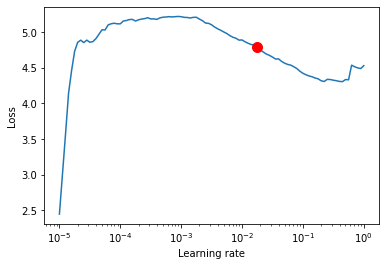

In [52]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    net, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader, 
    min_lr=1e-5
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [53]:
early_stop_callback = EarlyStopping(
    monitor = "val_loss", 
    min_delta = 1e-4, 
    patience = 20, 
    verbose = True, mode = "min")

trainer = pl.Trainer(
    max_epochs=200,
    gpus=0,
    weights_summary = "top",
    gradient_clip_val = 0.01,
    callbacks = [early_stop_callback],
    limit_train_batches = 30,
)


net = NBeats.from_dataset(
    training,
    learning_rate = 0.017,
    log_interval = 10,
    log_val_interval = 1,
    weight_decay = 1e-2,
    widths = [32, 512],
    backcast_loss_ratio = 1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.721     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.678


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.188 >= min_delta = 0.0001. New best score: 2.490


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.148 >= min_delta = 0.0001. New best score: 2.341


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.260 >= min_delta = 0.0001. New best score: 2.082


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0001. New best score: 2.040


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 2.040. Signaling Trainer to stop.


In [54]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [55]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1566)

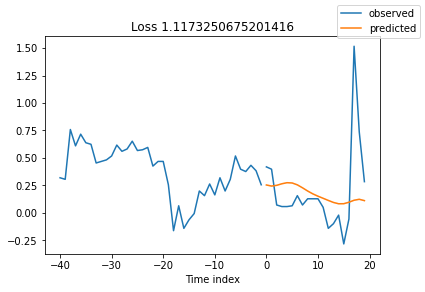

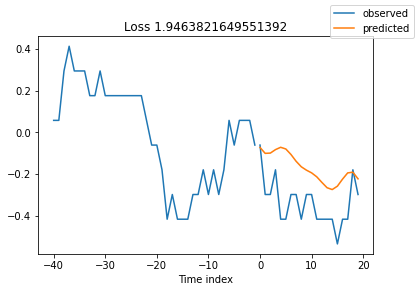

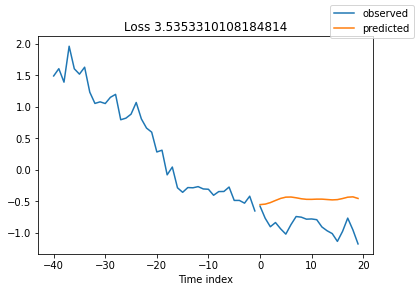

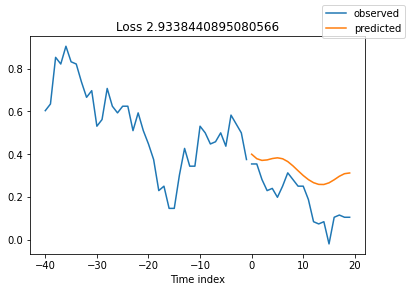

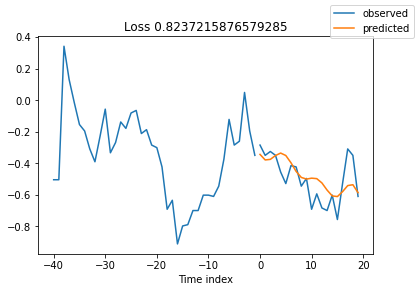

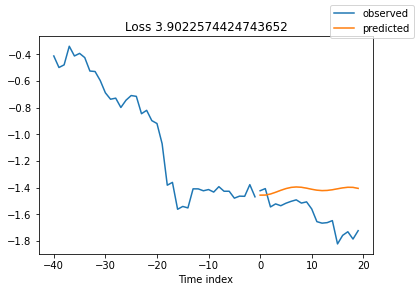

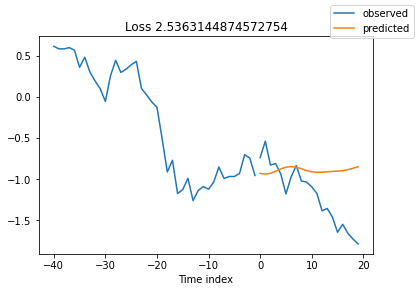

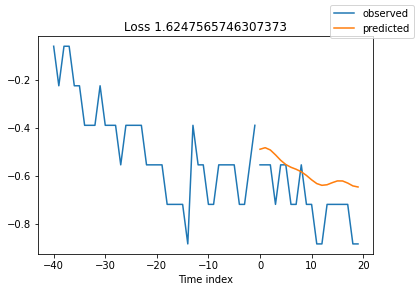

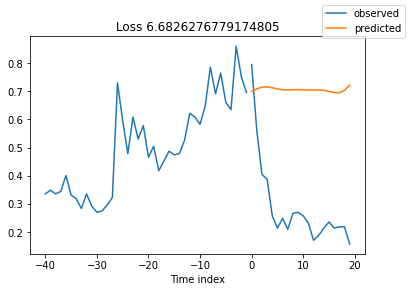

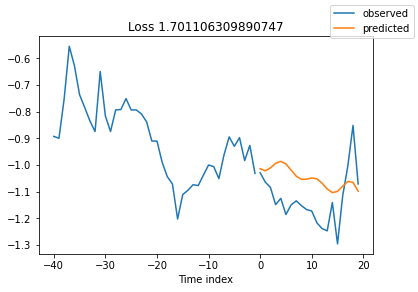

In [56]:
raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

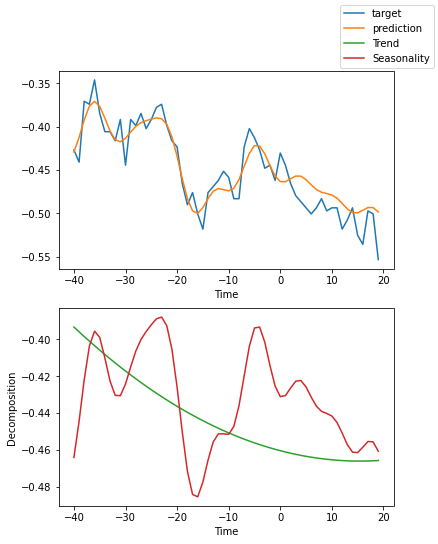

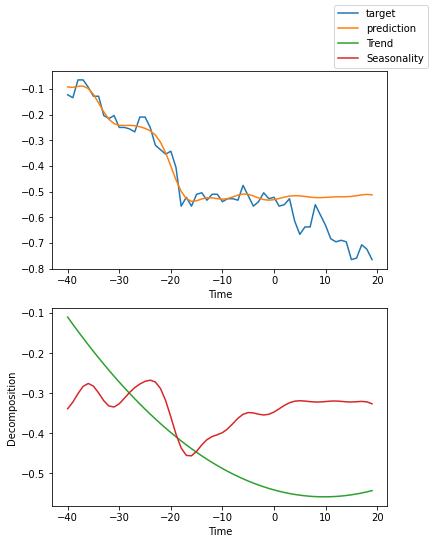

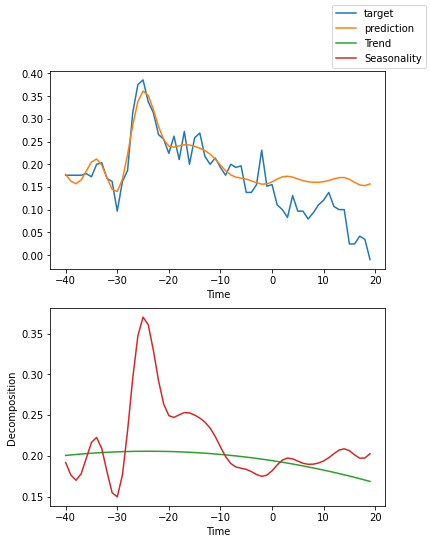

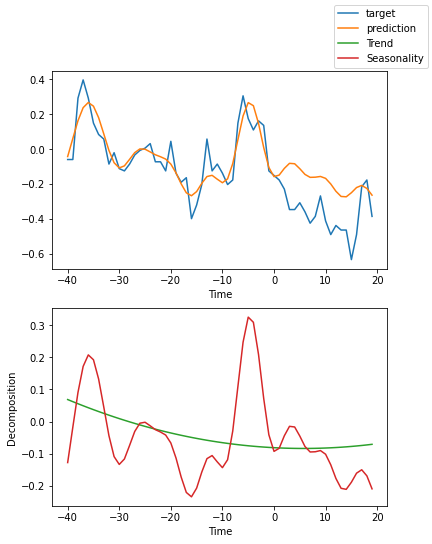

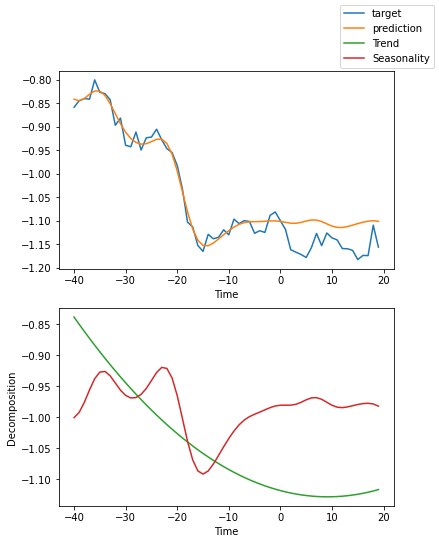

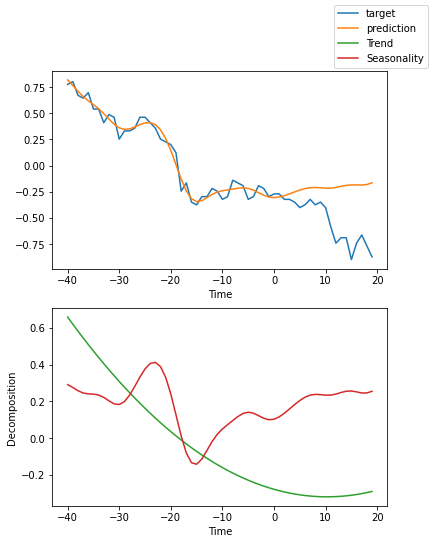

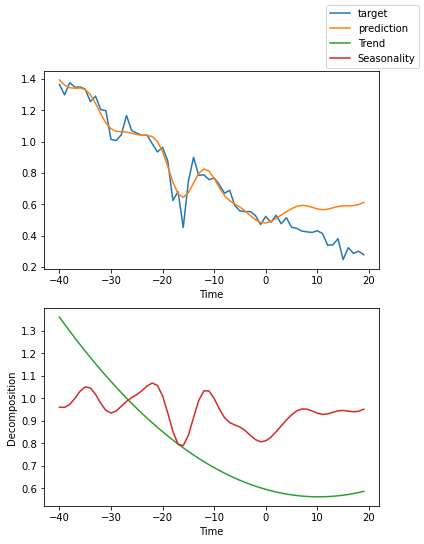

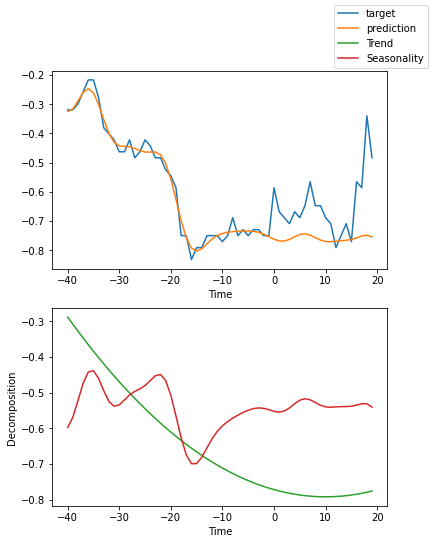

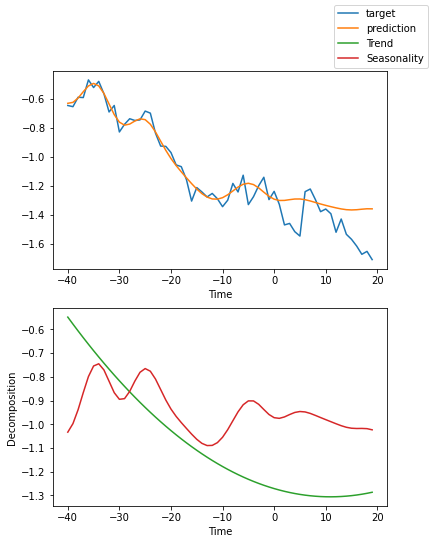

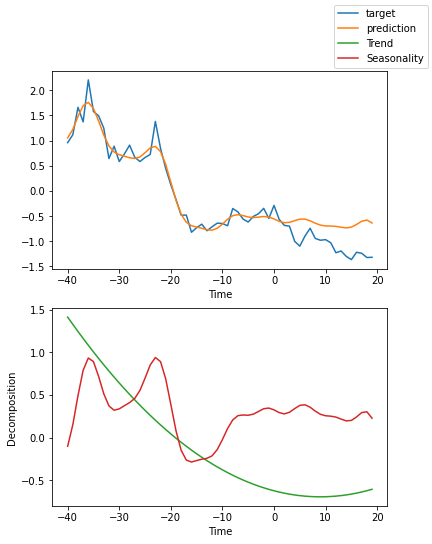

In [57]:
for idx in np.arange(20, 30):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx)